Set de SRC

In [7]:
import os
import sys
import pandas as pd
import geopandas as gpd
from sqlalchemy import create_engine
from dotenv import load_dotenv

import pyproj
import os

# 1. Definir la ruta exacta donde debería estar proj.db
# Nota: Uso r'' para evitar problemas con las barras invertidas de Windows
ruta_proj = r"c:\Users\mosqu\.conda\envs\tfm_env\Library\share\proj"

# 2. Verificar si el archivo realmente existe ahí (diagnóstico)
archivo_db = os.path.join(ruta_proj, 'proj.db')
if os.path.exists(archivo_db):
    print(f"✅ Archivo proj.db encontrado en: {archivo_db}")
else:
    print(f"❌ PELIGRO: No se encuentra proj.db en {ruta_proj}")

# 3. Forzar a pyproj a usar este directorio
pyproj.datadir.set_data_dir(ruta_proj)
print(f"🔄 Directorio de datos PROJ forzado a: {pyproj.datadir.get_data_dir()}")

# --- 1. CONFIGURACIÓN DEL ENTORNO ---
# Parche para Windows/Conda
proj_lib_path = os.path.join(sys.prefix, 'Library', 'share', 'proj')
os.environ['PROJ_LIB'] = proj_lib_path
print(f"1. Ruta PROJ configurada: {proj_lib_path}")

# Cargar variables
load_dotenv('../.env') 

# VERIFICACIÓN DE VARIABLES (IMPORTANTE)
# Si alguna sale 'None', es que no lee el archivo .env
user = os.getenv('DB_USER')
db_name = os.getenv('DB_NAME')
print(f"2. Usuario cargado: {user}") 
print(f"3. Base de datos objetivo: {db_name}")

if user is None or db_name is None:
    raise ValueError("¡ALERTA! No se está leyendo el archivo .env. Revisa que exista y tenga datos.")

# --- 2. PREPARACIÓN DE DATOS ---
print("4. Creando DataFrame...")
data = {'estacion': ['Test'], 'lat': [42.5], 'lon': [-8.8]}
df = pd.DataFrame(data)

print("5. Convirtiendo a GeoDataFrame (Test de Geometría)...")
# Aquí es donde fallaba antes
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
)
print("   -> Geometría creada correctamente.")

# --- 3. CONEXIÓN ---
print("6. Conectando a PostgreSQL...")
db_pass = os.getenv('DB_PASS')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
engine_url = f"postgresql://{user}:{db_pass}@{db_host}:{db_port}/{db_name}"
engine = create_engine(engine_url)

print("7. Escribiendo en la Base de Datos...")
# ALERTA: Si falla aquí, saldrá un texto rojo muy largo abajo. ESO ES LO QUE QUIERO VER.
gdf.to_postgis(name='test_conexion', con=engine, if_exists='replace')

print("✅ ¡ÉXITO FINAL! Si lees esto, todo funciona.")

✅ Archivo proj.db encontrado en: c:\Users\mosqu\.conda\envs\tfm_env\Library\share\proj\proj.db
🔄 Directorio de datos PROJ forzado a: c:\Users\mosqu\.conda\envs\tfm_env\Library\share\proj
1. Ruta PROJ configurada: c:\Users\mosqu\.conda\envs\tfm_env\Library\share\proj
2. Usuario cargado: postgres
3. Base de datos objetivo: tfm_arousa_db
4. Creando DataFrame...
5. Convirtiendo a GeoDataFrame (Test de Geometría)...
   -> Geometría creada correctamente.
6. Conectando a PostgreSQL...
7. Escribiendo en la Base de Datos...
✅ ¡ÉXITO FINAL! Si lees esto, todo funciona.


In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

# 1. Cargar variables del archivo .env
load_dotenv()  # Esto busca el archivo .env y carga las variables

# 2. Leer las variables (si no existen, devuelve None)
DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASS")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# 3. Crear conexión
conn_str = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(conn_str)

print("✅ Credenciales cargadas desde .env correctamente.")


# 2. Leer los datos desde PostGIS
# Usamos read_postgis que convierte automáticamente la columna geométrica
sql = 'SELECT * FROM test_conexion'
gdf_descarga = gpd.read_postgis(sql, con=engine, geom_col='geometry')

print("Datos descargados de la BD:")
print(gdf_descarga.head())

# 3. Visualización rápida interactiva
# Si tienes 'folium' y 'mapclassify' instalados, esto crea un mapa interactivo.
# Si falla, usaremos un plot estático.
try:
    mapa = gdf_descarga.explore(marker_type='marker', color='red')
    print("\nGenerando mapa interactivo (busca el punto rojo)...")
    display(mapa)
except Exception as e:
    print("\nNo se pudo generar mapa interactivo (falta folium/mapclassify), generando estático:")
    gdf_descarga.plot()
    plt.title("Punto descargado de PostGIS")
    plt.show()

✅ Credenciales cargadas desde .env correctamente.
Datos descargados de la BD:
  estacion   lat  lon           geometry
0     Test  42.5 -8.8  POINT (-8.8 42.5)

Generando mapa interactivo (busca el punto rojo)...


1. Iniciando conexión...
2. Descargando datos de PostGIS...
✅ ¡Datos descargados! Filas: 1
  estacion   lat  lon           geometry
0     Test  42.5 -8.8  POINT (-8.8 42.5)
3. Generando mapa estático...


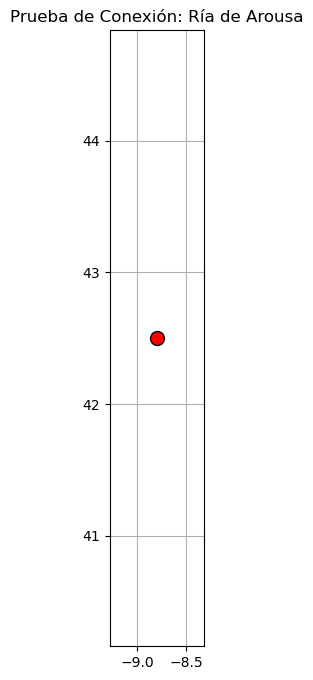

✅ SI VES EL PUNTO ROJO, YA TERMINAMOS LA CONFIGURACIÓN.


In [1]:
import os
# --- PARCHE PARA QUE EL KERNEL NO MUERA (Error 3228369023) ---
# Esto permite que librerías conflictivas convivan en Windows
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# -------------------------------------------------------------

import geopandas as gpd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv
import pyproj

# 1. Configurar PROJ (Tu parche de rutas)
ruta_proj = r"c:\Users\mosqu\.conda\envs\tfm_env\Library\share\proj"
pyproj.datadir.set_data_dir(ruta_proj)

# 2. Cargar credenciales
load_dotenv()
DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASS")
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")

print("1. Iniciando conexión...")

if not DB_PASS:
    print("❌ ERROR: Revisa tu archivo .env, no encuentra la contraseña.")
else:
    # Crear conexión
    conn_str = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:5432/{DB_NAME}"
    engine = create_engine(conn_str)

    # 3. Descargar datos
    sql = "SELECT * FROM test_conexion"
    try:
        print("2. Descargando datos de PostGIS...")
        gdf = gpd.read_postgis(sql, engine, geom_col='geometry')
        print(f"✅ ¡Datos descargados! Filas: {len(gdf)}")
        print(gdf.head())
        
        # 4. DIBUJAR (Usamos un plot estático simple para probar)
        print("3. Generando mapa estático...")
        
        fig, ax = plt.subplots(figsize=(10, 8))
        gdf.plot(ax=ax, color='red', markersize=100, edgecolor='black')
        
        plt.title("Prueba de Conexión: Ría de Arousa")
        plt.grid(True)
        plt.show()
        
        print("✅ SI VES EL PUNTO ROJO, YA TERMINAMOS LA CONFIGURACIÓN.")
        
    except Exception as e:
        print(f"\n❌ Error: {e}")